#Problem Statement
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

This is a simple classification problem  using this dataset , where a single layer neural network is used which acheived **87.47%** accuracy over the test set. 



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/drive')

## Train Set

In [ ]:
train_df = pd.read_csv('/drive/My Drive/Colab Notebooks/Fashion_dataset/fashion-mnist_train.csv')
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


### Data informations - shapes, classes, visualization

Labels: 

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

In [ ]:
labels = np.arange(10)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
label_dict = dict(zip(labels, class_names))

In [ ]:
print(len(train_df)) #length of whole train dataset

60000


In [ ]:
#shuffling the dataset
from sklearn.utils import shuffle
train_df = shuffle(train_df)

In [ ]:
# Separating Data and Label
Y = train_df["label"]
X = train_df.drop(labels = ["label"],axis = 1)

# Normalize the data
X = X / 255.0

# Reshape the array into 28 x 28 pixel
X = X.values.reshape(-1,28,28,1)
X.shape

(60000, 28, 28, 1)

In [ ]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

54000
54000
6000
6000


In [ ]:
X_train[0].shape

(28, 28, 1)

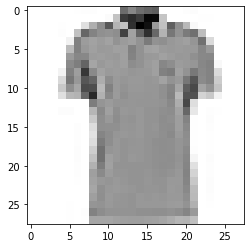

In [ ]:
#plotting image
show_img = X_train[0].reshape(28,28)
plt.imshow(show_img, cmap='binary')
#print(label_dict[y_train[0]])

In [ ]:
train_dataset = list(zip(X_train,y_train))
test_dataset = list(zip(X_test,y_test))

### Building the model

In [ ]:
# Hyperparameters

batch_size = 100
num_iters = 3000
input_dim = 28*28 # num_features = 784
num_hidden = 100 # num of hidden nodes
output_dim = 10

learning_rate = 0.1  

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

In [ ]:
class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer
        self.linear_1 = nn.Linear(input_size, num_hidden)

        ### Non-linearity
        self.relu = nn.ReLU()

        ### Output layer
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        # Linear layer
        out  = self.linear_1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = NeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

NeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (sigmoid): ReLU()
  (linear_out): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

###Training the model

In [ ]:
'''
TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float()) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Iteration , Loss and train accuracy
            print('Iteration: {}. Loss: {}. Train Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.3742339015007019. Train Accuracy: 85.96
Iteration: 1000. Loss: 0.2309747189283371. Train Accuracy: 87.39
Iteration: 1500. Loss: 0.27211323380470276. Train Accuracy: 87.63
Iteration: 2000. Loss: 0.2992387115955353. Train Accuracy: 87.28
Iteration: 2500. Loss: 0.36851951479911804. Train Accuracy: 87.58


##Test Set

In [ ]:
test_df = pd.read_csv('/drive/My Drive/Colab Notebooks/Fashion_dataset/fashion-mnist_test.csv')
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(len(test_df))

10000


In [ ]:
# Separating Data and Label
Y = test_df["label"]
X = test_df.drop(labels = ["label"],axis = 1)

# Normalize the data
X = X / 255.0

# Reshape the array into 28 x 28 pixel
X = X.values.reshape(-1,28,28,1)
X.shape

(10000, 28, 28, 1)

T-shirt/top


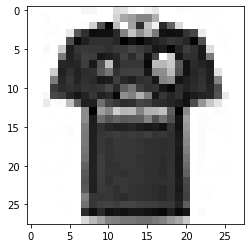

In [ ]:
#plotting image
show_img = X[0].reshape(28,28)
plt.imshow(show_img, cmap='binary')
print(label_dict[Y[0]])

In [ ]:
test_dataset = list(zip(X,Y))

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)  

### Testing the model accuracy 

In [ ]:
correct = 0
total = 0
for images, labels in test_loader:
  images = images.view(-1, 28*28).to(device)

  # Forward pass only to get logits/output
  outputs = model(images.float())

  # Get predictions from the maximum value
  _, predicted = torch.max(outputs, 1)

  # Total number of labels
  total += labels.size(0)


  # Total correct predictions
  if torch.cuda.is_available():
    correct += (predicted.cpu() == labels.cpu()).sum() 
  else:
    correct += (predicted == labels).sum()

accuracy = 100 * correct.item() / total

# Print Accuracy
print('Test Accuracy: {}'.format(accuracy))

Test Accuracy: 87.47
